# Understand Optimal Actions

In [1]:
## UROP Und

# Import and initialise device param
import time
from models.BaseAgent import BaseAgent
import gymnasium as gym
import torch
import numpy as np
from gym_examples.utils.population import PopulationSimulation
from models.HITLDQNAgent import HITLDQNAgent
from models.HITLDRQNAgent import HITLDRQNAgent

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [2]:
def train_w_reset_h(agent:BaseAgent, env:gym.Env, episodes: int, device, is_exploring:bool):
    """Train agent using gym environment while being offline"""

    rewards = []

    agent.reset_replay_memory() # Same train function has the same episodic memory
    agent.set_exploring(True)

    for i_episode in range(episodes):
        print(f'######------------------------------------EPISODE {i_episode}------------------------------------######')
        observation, info = env.reset()
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        ep_rewards = 0
        is_done = False        
        while not is_done:
            action = agent.select_action(state)
            observation, reward, terminated, truncated, info = env.step(action.item())
            reward = torch.tensor([np.float32(reward)], device=device)
            ep_rewards += reward
            
            is_done = terminated or truncated
            next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            agent.memorize(state, action, next_state, reward)
            state = next_state
            agent.optimize_model()

        rewards.append(ep_rewards.item())

        agent.reset_hidden_state() # Reset the hidden state of the agent

    return agent, rewards

In [3]:
from typing import List
from matplotlib import pyplot as plt

def plot_multiple_runs(all_rewards: List[List[int]]):
    all_rewards = np.array(all_rewards)

    # Calculate max, min, and mean rewards
    max_rewards = np.max(all_rewards, axis=0)
    min_rewards = np.min(all_rewards, axis=0)
    mean_rewards = np.mean(all_rewards, axis=0)

    # Plot the area graph
    plt.figure(figsize=(10, 5))
    plt.fill_between(range(len(max_rewards)), min_rewards, max_rewards, color='gray', alpha=0.3, label='Min to Max')
    plt.plot(mean_rewards, label='Mean', color='blue')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Reward Comparison over Multiple Runs')
    plt.legend()

    plt.ioff()
    plt.show()

######------------------------------------Run #0...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######


/Users/waishunlee/Documents/UROP/hitl_hvac/models/HITLDRQNAgent.py:151: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:334.)
  next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values


######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE 9------------------------------------######
######------------------------------------EPISODE 10------------------------------------######
######------------------------------------EPISODE 11------------------------------------######
######------------------------------------EPISODE 12------------------------------------######
######------------------------------------EPISODE 13------------------------------------######
######------------------------------------EPISODE 14----

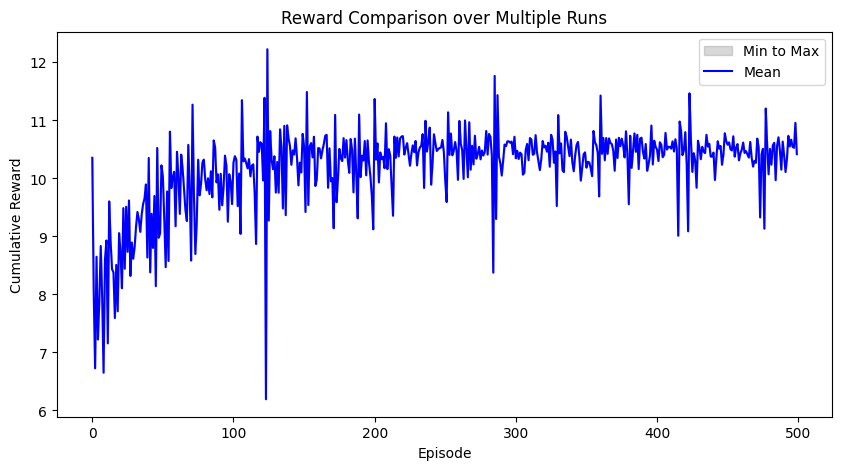

In [4]:
# DRQN vs DQN
# DRQN ideally should converge in a multiobjective POMDP scenario because it was able to converge in POMDP scenario
# 1. Optimal temp for agent trained only on HITL?
NUM_EPISODES = 500 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)
NUM_RUNS = 1

# Environment Initialisation
population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 200, 80)
env = gym.make("HITLAPOMDPirconEnvironment-v0", population_simulation=population, is_render=False, check_optimal=False ,w_usercomfort=1)

state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

all_rewards = []
for i in range(NUM_RUNS):
    cagent = HITLDRQNAgent(n_observations, n_actions, device, 
                        memory_size=10000, 
                        batch_size=64, 
                        gamma=0.99, 
                        eps_start=0.9, 
                        eps_end=0.05, 
                        eps_decay=1000, 
                        tau=0.005, 
                        lr=1e-4)
    print(f'######------------------------------------Run #{i}...------------------------------------######')
    cagent, rewards = train_w_reset_h(cagent, env, NUM_EPISODES, device, True)
    all_rewards.append(rewards)
plot_multiple_runs(all_rewards)

######------------------------------------Run #0...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE 9---------

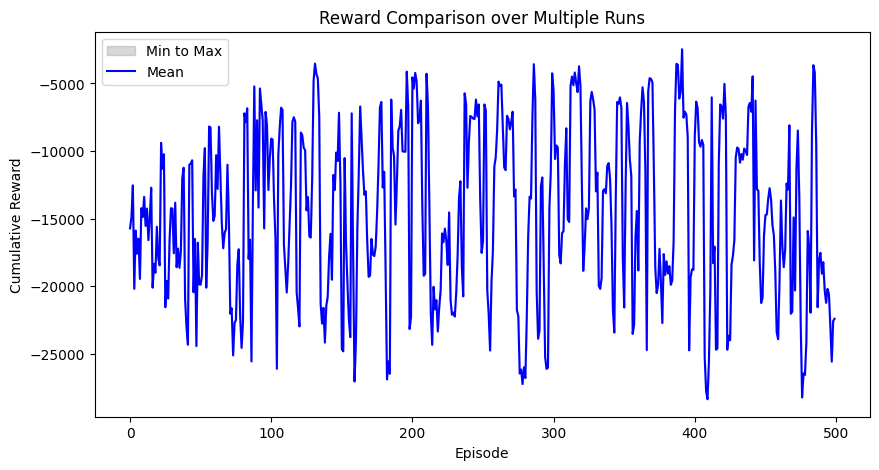

In [5]:
# Train agent with env with only energy rewards
population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 200, 80)

env = gym.make("EnergyOnlyAirconEnvironment-v0", population_simulation=population, is_render=False, check_optimal=False , w_energy=1)

state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

all_rewards = []
for i in range(NUM_RUNS):
    eagent = HITLDRQNAgent(n_observations, n_actions, device, 
                        memory_size=10000, 
                        batch_size=64, 
                        gamma=0.99, 
                        eps_start=0.9, 
                        eps_end=0.05, 
                        eps_decay=1000, 
                        tau=0.005, 
                        lr=1e-4)
    print(f'######------------------------------------Run #{i}...------------------------------------######')
    eagent, rewards = train_w_reset_h(eagent, env, NUM_EPISODES, device, True)
    all_rewards.append(rewards)
print(all_rewards)
plot_multiple_runs(all_rewards)

In [6]:
def multiobj_train_w_reset_h(agent:BaseAgent, env:gym.Env, episodes: int, device, is_exploring:bool):
    """Train agent using gym environment while being offline"""

    rewards = []
    comfort_rewards = []
    energy_rewards = []

    agent.reset_replay_memory() # Same train function has the same episodic memory
    agent.set_exploring(True)

    for i_episode in range(episodes):
        print(f'######------------------------------------EPISODE {i_episode}------------------------------------######')
        observation, info = env.reset()
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        ep_rewards = 0
        ep_comfort_rewards = 0
        ep_energy_rewards = 0
        is_done = False        
        while not is_done:
            action = agent.select_action(state)
            observation, reward, terminated, truncated, info = env.step(action.item())
            reward = torch.tensor([np.float32(reward)], device=device)
            ep_rewards += reward
            ep_comfort_rewards += info['comfort_score']
            ep_energy_rewards += info['power_score']

            is_done = terminated or truncated
            next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            agent.memorize(state, action, next_state, reward)
            state = next_state
            agent.optimize_model()

        rewards.append(ep_rewards.item())
        comfort_rewards.append(ep_comfort_rewards)
        energy_rewards.append(ep_energy_rewards)

        agent.reset_hidden_state() # Reset the hidden state of the agent

    return agent, rewards, comfort_rewards, energy_rewards

In [7]:
def multiobj_plot_multiple_runs(all_rewards: List[List[int]], all_comfort_rewards: List[List[int]], all_energy_rewards: List[List[int]]):
    # Convert lists to numpy arrays
    all_rewards = np.array(all_rewards)
    all_comfort_rewards = np.array(all_comfort_rewards)
    all_energy_rewards = np.array(all_energy_rewards)

    # Calculate max, min, and mean rewards for each objective
    max_rewards = np.max(all_rewards, axis=0)
    min_rewards = np.min(all_rewards, axis=0)
    mean_rewards = np.mean(all_rewards, axis=0)

    c_max_rewards = np.max(all_comfort_rewards, axis=0)
    c_min_rewards = np.min(all_comfort_rewards, axis=0)
    c_mean_rewards = np.mean(all_comfort_rewards, axis=0)

    e_max_rewards = np.max(all_energy_rewards, axis=0)
    e_min_rewards = np.min(all_energy_rewards, axis=0)
    e_mean_rewards = np.mean(all_energy_rewards, axis=0)

    # Plot the area graphs
    plt.figure(figsize=(10, 5))

    # Plot for overall reward
    plt.fill_between(range(len(max_rewards)), min_rewards, max_rewards, color='gray', alpha=0.3, label='Overall Min to Max')
    plt.plot(mean_rewards, label='Overall Mean', color='blue')

    # Plot for comfort reward
    plt.fill_between(range(len(c_max_rewards)), c_min_rewards, c_max_rewards, color='lightgreen', alpha=0.3, label='Comfort Min to Max')
    plt.plot(c_mean_rewards, label='Comfort Mean', color='green')

    # Plot for energy reward
    plt.fill_between(range(len(e_max_rewards)), e_min_rewards, e_max_rewards, color='lightcoral', alpha=0.3, label='Energy Min to Max')
    plt.plot(e_mean_rewards, label='Energy Mean', color='red')

    # Set labels and title
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Multi-objective Reward Comparison over Multiple Runs')
    plt.legend()

    plt.show()


######------------------------------------Run #0...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE 9---------

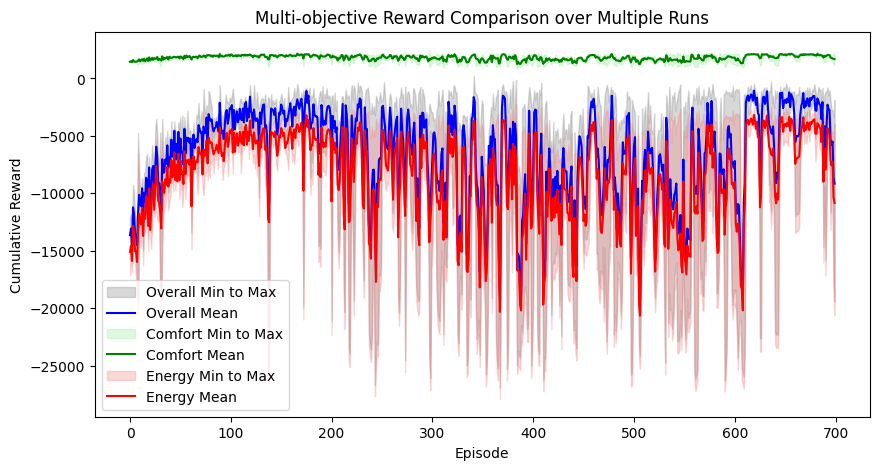

In [8]:
# Train agent with env with both energy and comfort rewards
NUM_RUNS = 3
NUM_EPISODES = 700
population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 200, 80)

env = gym.make("AirconEnvironment-v0", population_simulation=population, is_render=False, check_optimal=False , w_usercomfort=200, w_energy=1)

state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

all_rewards = []
all_comfort_rewards = []
all_energy_rewards = []
for i in range(NUM_RUNS):
    agent = HITLDRQNAgent(n_observations, n_actions, device, 
                        memory_size=10000, 
                        batch_size=64, 
                        gamma=0.99, 
                        eps_start=0.9, 
                        eps_end=0.05, 
                        eps_decay=1000, 
                        tau=0.005, 
                        lr=1e-4)
    print(f'######------------------------------------Run #{i}...------------------------------------######')
    agent, rewards, comfort_rewards, energy_rewards = multiobj_train_w_reset_h(agent, env, NUM_EPISODES, device, True)
    all_rewards.append(rewards)
    all_comfort_rewards.append(comfort_rewards)
    all_energy_rewards.append(energy_rewards)

multiobj_plot_multiple_runs(all_rewards, all_comfort_rewards, all_energy_rewards)

In [ ]:
# Decompose training loop
# Loop at the optimal actions plotted by the two DRQN agents trained using two different reward functions
# And the respective rewards of the two agents

# agent_comfort (trained only on comfort), agent_energy (trained only on energy) compare the optimal actions take as well as the results

w_usercomfort=1
w_energy=1
# w_sum = w_usercomfort + w_energy
# w_usercomfort /=w_sum
# w_energy /=w_sum
env = gym.make("AirconEnvironment-v0", population_simulation=population, is_render=False, check_optimal=False ,w_usercomfort=w_usercomfort, w_energy=w_energy)
cagent.set_exploring(False)
eagent.set_exploring(False)
agent.set_exploring(False)


for i_episode in range(100):
    print(f'######------------------------------------EPISODE {i_episode}------------------------------------######')
    observation, info = env.reset()
    state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    # ep_rewards = 0
    # ep_comfort_rewards = 0
    # ep_energy_rewards = 0
    # cep_rewards = [0, 0, 0] # of size 3 ep_rewards, ep_comfort_rewards, ep_energy_rewards
    # eep_rewards = [0, 0, 0] # of size 3 ep_rewards, ep_comfort_rewards, ep_energy_rewards

    is_done = False        
    while not is_done:
        caction = cagent.select_action(state)
        eaction = eagent.select_action(state)
        action = agent.select_action(state)

        print(f'Cagent:{caction}, Eagent:{eaction}, Agent:{action}')

        # TODO: Track the reward changes, Calculate theorectical rewards for eagent (without stepping in env)
        # env.get_reward(eaction)
        # env._get_info()

        observation, reward, terminated, truncated, info = env.step(action.item())

        # reward = torch.tensor([np.float32(reward)], device=device)
        # ep_rewards += reward
        is_done = terminated or truncated
        next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        state = next_state

In [9]:
cagent.save_model("./runs/saved_models/cagent_hitl_pomdp_1705")
eagent.save_model("./runs/saved_models/eagent_hitl_pomdp_1705")
agent.save_model("./runs/saved_models/agent_hitl_pomdp_1705")